# Наивный Байес и спам
__Суммарное количество баллов: 10__


In [243]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import spacy
from nltk.stem.snowball import SnowballStemmer
from scipy.stats import multinomial as mnom

In [3]:
import re
def read_dataset(filename):
    file = open(filename, encoding="utf-8")
    x = []
    y = []
    for line in file:
        cl, sms = re.split("^(ham|spam)[\t\s]+(.*)$", line)[1:3]
        x.append(sms)
        y.append(cl)
    return np.array(x, dtype=np.str), np.array(y, dtype=np.str)

In [461]:
def get_precision_recall_accuracy(y_pred, y_true):
    classes = np.unique(list(y_pred) + list(y_true))
    true_positive = dict((c, 0) for c in classes)
    true_negative = dict((c, 0) for c in classes)
    false_positive = dict((c, 0) for c in classes)
    false_negative = dict((c, 0) for c in classes)
    for c_pred, c_true in zip(y_pred, y_true):
        for c in classes:
            if c_true == c:
                if c_pred == c_true:
                    true_positive[c] = true_positive.get(c, 0) + 1
                else:
                    false_negative[c] = false_negative.get(c, 0) + 1
            else:
                if c_pred == c:
                    false_positive[c] = false_positive.get(c, 0) + 1
                else:
                    true_negative[c] = true_negative.get(c, 0) + 1
    precision = dict((c, true_positive[c] / (true_positive[c] + false_positive[c])) for c in classes)
    recall = dict((c, true_positive[c] / (true_positive[c] + false_negative[c])) for c in classes)
    accuracy = sum([true_positive[c] for c in classes]) / len(y_pred)
    return precision, recall, accuracy

def plot_precision_recall(X_train, y_train, X_test, y_test, bow_method, voc_sizes=range(20, 200, 5)):
    classes = np.unique(list(y_train) + list(y_test))
    precisions = dict([(c, []) for c in classes])
    recalls = dict([(c, []) for c in classes])
    accuracies = []
    for v in voc_sizes:
        bow = bow_method(X_train, voc_limit=v)
        X_train_transformed = bow.transform(X_train)
        X_test_transformed = bow.transform(X_test)
        classifier = NaiveBayes(0.001)
        classifier.fit(X_train_transformed, y_train)
        y_pred = classifier.predict(X_test_transformed)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in classes:
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("Vocabulary size")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(list(ys.values()))-0.01, np.max(list(ys.values()))+0.01)
        for c in ys.keys():
            plt.plot(x, ys[c], label="Class " + str(c))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(voc_sizes, recalls, "Recall")
    plot(voc_sizes, precisions, "Precision")
    plot(voc_sizes, {"":accuracies}, "Accuracy", legend=False)

In [5]:
X, y = read_dataset("spam")

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

In [7]:
X_train

array(['Had your mobile 10 mths? Update to latest Orange camera/video phones for FREE. Save £s with Free texts/weekend calls. Text YES for a callback orno to opt out',
       "Erm … ill pick you up at about 6.45pm. That'll give enough time to get there, park and that.",
       "Thank you so much. When we skyped wit kz and sura, we didnt get the pleasure of your company. Hope you are good. We've given you ultimatum oh! We are countin down to aburo. Enjoy!",
       ..., 'Right on brah, see you later',
       "The affidavit says  &lt;#&gt;  E Twiggs St, division g, courtroom  &lt;#&gt; , &lt;TIME&gt;  AM. I'll double check and text you again tomorrow",
       'You call him and tell now infront of them. Call him now.'],
      dtype='<U910')

### Задание 1 (3 балла)
Реализуйте классификацию методом Байеса в предположении независимости компонент `x`. При реализации следует считать, что значения каждой компоненты дискретны, а `p(x|y)` имеет мультиномиальное распределение.

#### Методы
`fit(X, y)` - оценивает параметры распределения `p(x|y)` для каждого `y`. 

`log_proba(X)` - для каждого элемента набора `X` считает логарифм вероятности отнести его к каждому классу. По теореме Байеса: `p(y|x) = p(y)p(x|y)/p(x)`. Соответственно, после логарифмирования: `log p(y|x) = log p(y) + log p(x|y) - log p(x)`. Поскольку `log p(x)` является независящей от класса `y` константой, это слагаемое никак не влияет на решение задачи максимизации. Поэтому его можно просто убрать для простоты.

In [306]:
def multinomial(lst):
    res, i = 1, 1
    for a in lst:
        for j in range(1,a+1):
            res *= i
            res //= j
            i += 1
    return res

In [450]:
class NaiveBayes:
    def __init__(self, alpha):
        self.alpha = alpha # Параметр аддитивной регуляризации
    def fit(self, X, y):
        self.classes, counts = np.unique(y_train, return_counts=True)
        groupedByClassSum = X.groupby(y).sum()
        self.Pxy = (groupedByClassSum + self.alpha).divide(groupedByClassSum.sum(axis=1)+self.alpha*X.shape[1], axis=0)
        self.Py = counts/sum(counts)

    def predict(self, X):
        return self.log_proba(X).idxmax(axis=1)
    
    def log_proba(self, X):
        #multinomial(np.array(X_test_bows[0:1], dtype=np.int)[0])
        X_df = X.apply(lambda x: pandas.Series(mnom.logpmf(x.values, x.sum(axis=0), self.Pxy.values)), axis=1) + np.log(self.Py)
        X_df.columns = self.classes
        return X_df.fillna(-100000)
        return X.apply(lambda x: (x*np.log(predictor.Pxy)).sum(axis=1), axis=1) + np.log(predictor.Py)

### Задание 2 (3 балла)
Теперь реализуем метод bag of words. Задача состоит в том, чтобы посчитать количество вхождений каждого слова в предложение.

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [478]:
class BoW:
    def __init__(self, X, voc_limit=1000, stemming=False):
        self.dict = {}
        self.stemming = stemming
        self.stemmer = SnowballStemmer("english")
        for x in X:
            for word in x.split(' '):
                prep_word = word.replace(',','').replace('.','').replace(' ','').replace(':','').lower()
                if(stemming):
                    prep_word = self.stemmer.stem(prep_word)
                if(len(prep_word)>1):
                    if prep_word in self.dict:
                        self.dict[prep_word]+=1
                    else:
                        self.dict[prep_word] = 1
        self.dict = sorted(self.dict.items(), key=lambda item: -item[1])[:voc_limit]
        self.dict = np.array([kv[0] for kv in self.dict])
    def _countOfWords(self, words):
        vfunc = np.vectorize(lambda word: words.count(word))
        return vfunc(self.dict)
        
    def transform(self, X):
        res = []
        for x in X:
            xWord = x.lower()
            if(self.stemming):
                xWord = self.stemmer.stem(xWord)
            res.append(self._countOfWords((xWord.split(' '))))
        return pandas.DataFrame(res)

In [487]:
bow = BoW(X_train, voc_limit=500)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)

In [480]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bow, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bow), y_test)

({'ham': 0.9877800407331976, 'spam': 0.8955223880597015},
 {'ham': 0.9857723577235772, 'spam': 0.9090909090909091},
 0.9767025089605734)

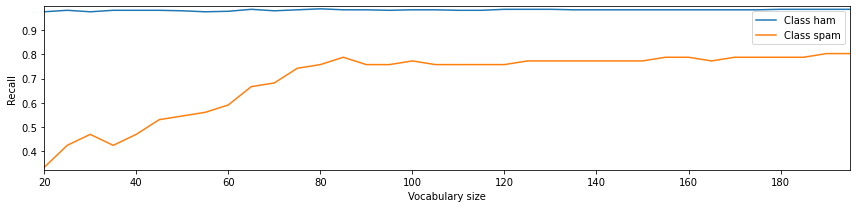

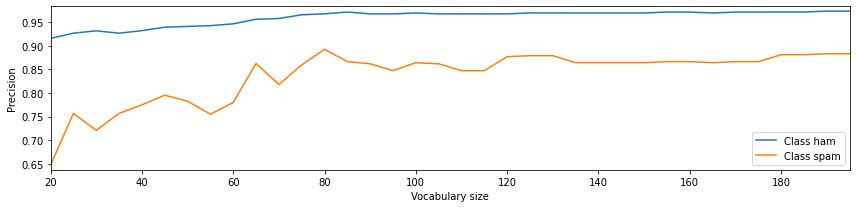

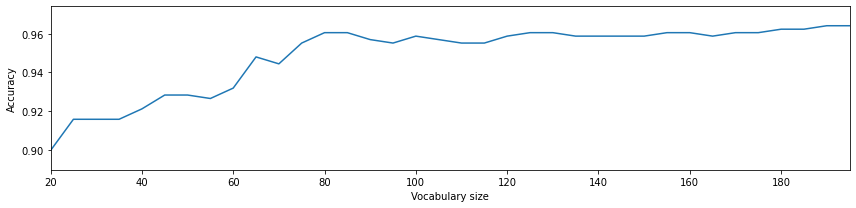

In [462]:
plot_precision_recall(X_train, y_train, X_test, y_test, BoW)

### Задание 3 (2 балла)
Теперь добавим в BoW стемминг. Для этого нам понадобится класс SnowballStemmer из пакета `nltk`

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [481]:
class BowStem (BoW):
    def __init__(self, X, voc_limit=1000):
        super(BowStem, self).__init__(X, voc_limit, stemming=True)

In [488]:
bows = BowStem(X_train, voc_limit=500)
X_train_bows = bows.transform(X_train)
X_test_bows = bows.transform(X_test)

In [483]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bows, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bows), y_test)

({'ham': 0.9778225806451613, 'spam': 0.8870967741935484},
 {'ham': 0.9857723577235772, 'spam': 0.8333333333333334},
 0.967741935483871)

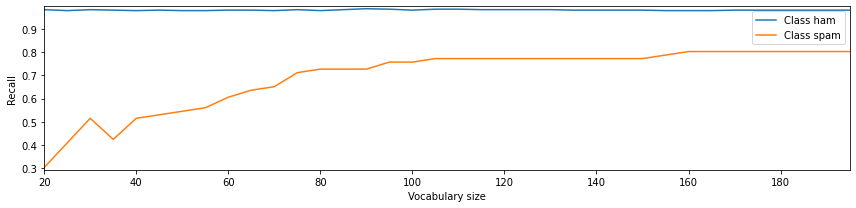

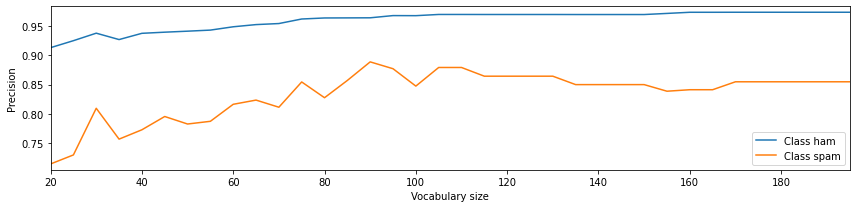

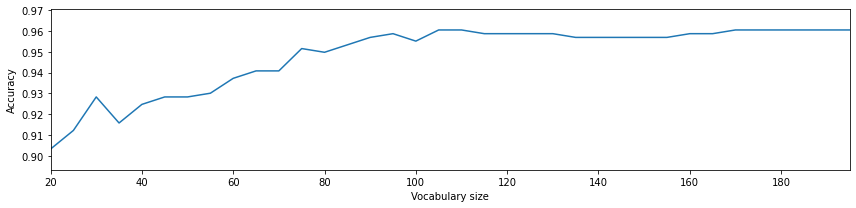

In [484]:
plot_precision_recall(X_train, y_train, X_test, y_test, BowStem)

In [264]:
X_test_bows
#multinomial.logpmf(n = 5)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1,2,0,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
554,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
555,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
556,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [225]:
X_test_bows[0:1]

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
